In [1]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib
# !pip install torchmetrics
# !pip install torch=='1.13.0' #!pip install torch=='1.7.1' #
# !pip install PyYAML
# !pip install --upgrade huggingface_hub
# !pip install reformer_pytorch==1.4.4
# !pip install sktime==0.16.1
# !pip install sympy==1.11.1
# !pip3 uninstall -y torch
# !conda install cudnn=8.4.1
# 


In [2]:
%load_ext autoreload
%autoreload 2

import grequests

from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory
from src.utils import create_3d_array, standardize, rolling_mean_diff, generate_univariate_data_labels, generate_data_labels_from_3d_array
from src.projection_layers import LSTMMaskedAutoencoderProjection, MLPMaskedAutoencoderProjection, TransformerEncoderProjectionLayer
from src.projection_layers import *
from src.dataset import TSDataset, ImputationDataset
from src.dataloader import TSDataLoader
from src.TFC.dataloader import TFCDataset
from src.encoders import TFC
from src.configs import Configs, ModelConfig
from src.RevIN import RevIN
from src.TSFM import TSFM


import torch
import torch.nn as nn
import torch.fft as fft

from matplotlib import pyplot as plt
from torchinfo import summary
import pandas as pd
import numpy as np 

import sys
sys.setrecursionlimit(50000000)


/opt/conda/envs/baseline/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/envs/baseline/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from lumnisfactors import LumnisFactors
from KEYS import LUMNIS_API_KEY

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc_raw     = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_eth_raw     = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-16")
temp_df_xmr_raw     = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")
ob_df_raw           = lumnis.get_historical_data("orderbook_snapshot_5", "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-16")


In [5]:
ob_df               = rolling_mean_diff(ob_df_raw, [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000], 'standard')

In [6]:
temp_df_btc         = rolling_mean_diff(temp_df_btc_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')
temp_df_eth         = rolling_mean_diff(temp_df_eth_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')
temp_df_xmr         = rolling_mean_diff(temp_df_xmr_raw, [ 5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000 ], type='standard')


cols                = temp_df_btc.columns #['close', 'volume'] #
max_seq_len         = 150

btc_array           = create_3d_array(temp_df_btc[cols], temp_df_btc.index, max_seq_len)
eth_array           = create_3d_array(temp_df_eth[cols], temp_df_eth.index, max_seq_len)
xmr_array           = create_3d_array(temp_df_xmr[cols], temp_df_xmr.index, max_seq_len)

# x_data_f = fft.fft(torch.from_numpy( temp_df_btc.values )).abs()
# ( temp_df_btc_raw / temp_df_btc_raw.rolling(1000).max() )['volume'].plot()
# standardize(temp_df_btc, 500, type='standard')['close'].plot()

In [7]:
date            = temp_df_btc[cols].reset_index()[['index']].rename(columns={'index': 'date'})
date['date']    = pd.to_datetime(date['date'])
date['month']   = date.date.apply(lambda row: row.month, 1)

date['day']     = date.date.apply(lambda row: row.day, 1)
date['weekday'] = date.date.apply(lambda row: row.weekday(), 1)
date['hour']    = date.date.apply(lambda row: row.hour, 1)
# date['minute'] = date.date.apply(lambda row: row.minute, 1)
# date['second'] = date.date.apply(lambda row: row.second, 1)
date            = date.drop(['date'], axis=1)

In [8]:
univariate_array     = create_3d_array(temp_df_eth_raw[['close']], temp_df_eth_raw.index, max_seq_len)

In [9]:
uni_data, uni_labels = generate_univariate_data_labels(univariate_array)

In [10]:


data_btc, labels_btc = generate_data_labels_from_3d_array(btc_array)
data_eth, labels_eth = generate_data_labels_from_3d_array(eth_array)
data_xmr, labels_xmr = generate_data_labels_from_3d_array(xmr_array)

In [11]:
# Prepare your data as a dictionary
data_dict = {
    'dataset_btc': {'data': data_btc, 'labels': labels_btc},
    'dataset_eth': {'data': data_eth, 'labels': labels_eth},
    'dataset_xmr': {'data': data_xmr, 'labels': labels_xmr},#xmr_array,
    'univariate': {"data": uni_data, "labels": uni_labels}
}

# data_dict['univariate'] = {"data": [], "labels": []}

# for key in data_dict.keys():
#     if key == 'univariate': continue

#     num_points   = data_dict[key].shape[0]
#     len_ts       = data_dict[key].shape[1]
#     num_channels = data_dict[key].shape[2]

#     for i in range(num_points - len_ts):
#         for channel in range(num_channels):
#             x = data_dict[key][i][:, channel]
#             y = data_dict[key][i+len_ts][:, channel]
            
#             x = np.expand_dims(x, axis=1)
#             y = np.expand_dims(y, axis=1)

#             data_dict['univariate']['data'].append(x)
#             data_dict['univariate']['labels'].append(y)

# data_dict['univariate']['data'] = np.array(data_dict['univariate']['data'])
# data_dict['univariate']['labels'] = np.array(data_dict['univariate']['labels'])


for key in data_dict.keys():
    if type(data_dict[key]) == dict: 
        data_dict[key]['data'] = torch.from_numpy( data_dict[key]['data'] ).to(torch.float32)
        data_dict[key]['labels'] = torch.from_numpy( data_dict[key]['labels'] ).to(torch.float32)
    else:
        data_dict[key] = torch.from_numpy( data_dict[key] ).to(torch.float32)
        
# Create instances of TSDataset for each dataset
datasets = { name: (TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) if type(data)==dict
          else ImputationDataset(data, masking_ratio=0.25)) for name, data in data_dict.items() }

# datasets = { name: TSDataset(data['data'], data['labels'], max_len=max_seq_len, shuffle=True) for name, data in data_dict.items() }


# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=512, max_len=max_seq_len, collate_fn='unsuperv', shuffle=False)

num_epochs = 4


In [12]:
for epoch in range(num_epochs):
    for batch_data in ts_data_loader:
        for dataset_name, data in batch_data.items():
            
            ds_type = ts_data_loader.datasets[dataset_name]
            if isinstance(ds_type, ImputationDataset):
                inputs, targets, target_masks, padding_masks = data
                print(dataset_name, "inputs shape: ", inputs.shape, "targets shape: ", targets.shape, "target_masks shape: ", target_masks.shape, "padding_masks shape: ", padding_masks.shape)
            elif isinstance(ds_type, TSDataset):
                if len(data) == 3:
                    inputs, labels, padding_masks = data
                    data_time_feat, label_time_feat = None, None
                else:
                    inputs, labels, padding_masks, data_time_feat, label_time_feat = data
                print(dataset_name, "inputs shape: ", inputs.shape, "labels shape: ", labels.shape, "padding_masks shape: ", padding_masks.shape)
        
            # if dataset_name == 'univariate':
            #     assert 1 == 0
            # print(dataset_name, inputs.shape)
            # print(dataset_name, inputs.shape, padding_masks.shape, targets.shape, target_masks.shape)
        break

dataset_btc inputs shape:  torch.Size([512, 150, 104]) labels shape:  torch.Size([512, 150, 104]) padding_masks shape:  torch.Size([512, 150])
dataset_eth inputs shape:  torch.Size([512, 150, 104]) labels shape:  torch.Size([512, 150, 104]) padding_masks shape:  torch.Size([512, 150])
dataset_xmr inputs shape:  torch.Size([512, 150, 104]) labels shape:  torch.Size([512, 150, 104]) padding_masks shape:  torch.Size([512, 150])
univariate inputs shape:  torch.Size([512, 150, 1]) labels shape:  torch.Size([512, 150, 1]) padding_masks shape:  torch.Size([512, 150])


In [13]:
from src.Time_Series_Library.models import Informer
model_config = ModelConfig( task_name='imputation', enc_in=inputs.shape[-1], dec_in=inputs.shape[-1],  c_out=inputs.shape[-1],
                 d_model=32, n_heads=4, e_layers=2,  d_layers=1,  d_ff=64,
                 dropout=0.1, activation='relu',  factor=5, freq='h',
                 embed='fixed', output_attention=False, distil=True,
                 pred_len=24, label_len=24, num_class=1) 

informer    = Informer(model_config)
informer(inputs, None, inputs, None).shape

torch.Size([512, 150, 1])

In [14]:
from src.projection_layers import Unsqueeze

Unsqueeze(-1)(inputs).shape

torch.Size([512, 150, 1, 1])

In [15]:
# Init parameters
input_dims  = data_btc.shape[1:]#uni_data.shape[1:] #(, 1)#btc_array.shape[1:]
hidden_dims = 64
output_dims = 64
use_revin   = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create an instance of the model
masked_ae = LSTMMaskedAutoencoderProjection(input_dims[1], hidden_dims, output_dims, device=device, use_revin=use_revin, loss_type='mae', use_gru=False)

# masked_ae =  MLPMaskedAutoencoderProjection(input_dims[1], hidden_dims, output_dims, device=device, use_revin=use_revin, lose_type='mae')
# masked_ae  = TransformerEncoderProjectionLayer(input_dims[1], hidden_dims, output_dims, device=device, n_heads=1,
#                     num_layers=1, max_len=max_seq_len, use_revin=use_revin, loss_type='mae', pos_encoding='learnable', dropout=0.1, norm='LayerNorm')



# Print the model summary
input_shape     = (128,) + input_dims
padding_shape = (128, max_seq_len)
print( summary(masked_ae, (input_shape, padding_shape), dtypes=[torch.float32, torch.bool, ]))
# print( summary(masked_ae, (input_shape, ), dtypes=[torch.float32, ]))

# summary(tfc, ((64, 50, 104), (64, 50, 104), (64, 50)), dtypes=[torch.float32, torch.float32, torch.bool])

# Train the model
losses = masked_ae.warmup(dataset=datasets['dataset_btc'], max_len=max_seq_len, n_epochs=30, 
                          batch_size=512, learning_rate=1e-2, log=True, 
                          data_set_type=type( datasets['dataset_btc'] ), collate_fn='unsuperv',
                          scheduler_step_size= 75, scheduler_gamma=0.1, verbose=True
                          )

RuntimeError: cuDNN version incompatibility: PyTorch was compiled  against (8, 5, 0) but found runtime version (8, 4, 1). PyTorch already comes bundled with cuDNN. One option to resolving this error is to ensure PyTorch can find the bundled cuDNN.Looks like your LD_LIBRARY_PATH contains incompatible version of cudnnPlease either remove it from the path or install cudnn (8, 5, 0)

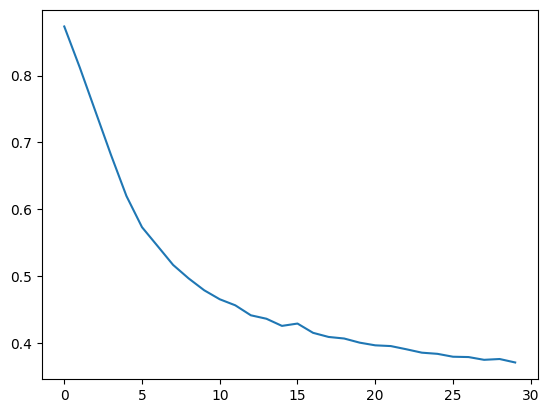

In [ ]:
plt.plot(losses)

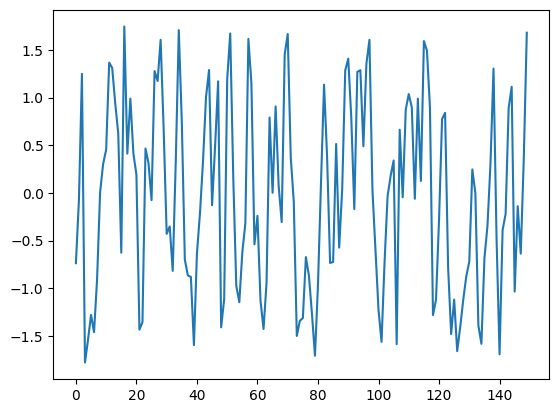

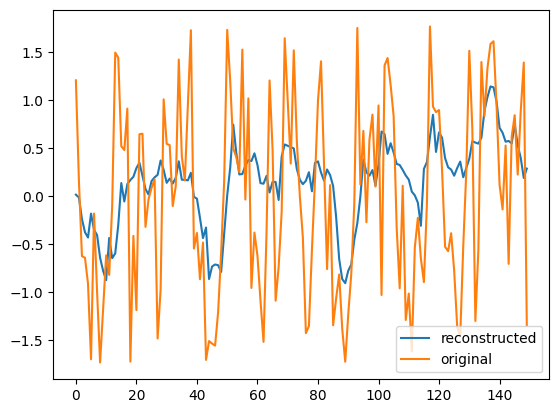

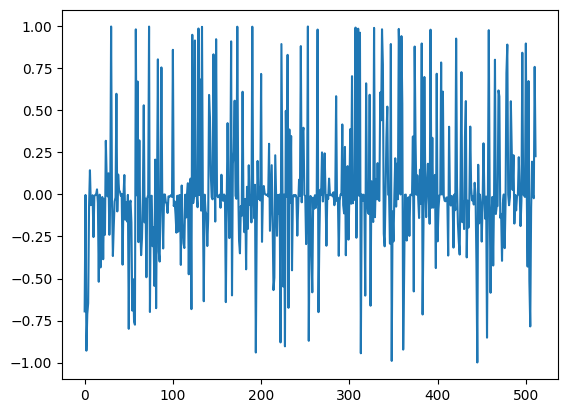

: 

In [ ]:
reconstructed_input = masked_ae(inputs.to(device), padding_masks.to(device), training=False)

channel  = 1
instance = 7

for channel in range(0, 1):
    plt.figure()
    plt.plot(inputs[instance][:,channel].detach().numpy()) 
    plt.show()
    plt.plot(reconstructed_input[instance][:,channel].detach().cpu().numpy(), label='reconstructed')
    plt.plot(labels[instance][:,channel].detach().cpu().numpy(), label='original') 
    plt.legend()
    

    plt.show()
    

embeddings = masked_ae.encode(inputs.to(device), type_of_pooling='last')
plt.plot( embeddings[:,1].detach().cpu().numpy() )

In [ ]:
embeddings.detach().cpu().numpy().shape

(512, 64)

In [ ]:
config_kwargs = {}
config_kwargs['batch_size']          = 128
config_kwargs['input_channels']      = data_dict['dataset_btc'].shape[-1]
config_kwargs['timesteps']           = data_dict['dataset_btc'].shape[1]
config_kwargs['TSlength_aligned']    = max_seq_len


configs = Configs(**config_kwargs)
labels = torch.zeros((data_dict['dataset_btc'].shape[0], 1))
ds = {"samples": data_dict['dataset_btc'], "labels": labels}

tfc_ds = TFCDataset(ds, configs, "pre_train", target_dataset_size=configs.batch_size, subset=False)

KeyboardInterrupt: 

In [ ]:
from src.encoders import TFC
configs = Configs(TSlength_aligned=50, 
                  features_len=inputs.shape[-1], 
                  features_len_f=inputs.shape[-1], 
                  n_head=1,
                  dim_feedforward=128,
                  num_transformer_layers=1,
                  encoder_layer_dims=128,
                  linear_encoder_dim=128,
                  channel_output_size=10,
                  time_output_size=10
                  )
tfc     = TFC(configs)

summary(tfc, ((64, 50, 104), (64, 50, 104), (64, 50)), dtypes=[torch.float32, torch.float32, torch.bool])

Layer (type:depth-idx)                             Output Shape              Param #
TFC                                                [64, 100]                 --
├─TSTransformerEncoder: 1-1                        [64, 50, 104]             --
│    └─Linear: 2-1                                 [50, 64, 128]             13,440
│    └─LearnablePositionalEncoding: 2-2            [50, 64, 128]             6,400
│    │    └─Dropout: 3-1                           [50, 64, 128]             --
│    └─TransformerEncoder: 2-3                     [50, 64, 128]             --
│    │    └─ModuleList: 3-2                        --                        99,584
│    └─Dropout: 2-4                                [64, 50, 128]             --
│    └─Linear: 2-5                                 [64, 50, 104]             13,416
├─Sequential: 1-2                                  [64, 100]                 --
│    └─AdaptiveAvgPool2d: 2-6                      [64, 10, 10]              --
│    └─Flatten: 2-7 

In [ ]:
input_data_shapes_dict  = {name: data.shape[1:] for name, data in data_dict.items()}

encoder_configs         = Configs(TSlength_aligned=max_seq_len, 
                                    features_len=inputs.shape[-1], 
                                    features_len_f=inputs.shape[-1], 
                                    n_head=1,
                                    dim_feedforward=128,
                                    num_transformer_layers=1,
                                    encoder_layer_dims=128,
                                    linear_encoder_dim=256,
                                    channel_output_size=10,
                                    time_output_size=10,
                                    d_model=128,
                                    pos_encoding='learnable',
                                    transformer_activation='gelu',
                                    transformer_normalization_layer='BatchNorm',
                                    freeze=False,
                                )

tsfm                    = TSFM(input_data_shapes_dict, 
                                batch_size=1024, 
                                lr=1e-3, 
                                log=True, 
                                device='cpu',
                                max_seq_length=max_seq_len,
                                encoder_config=encoder_configs
                                )

In [ ]:
from src.mvts_transformer.ts_transformer import TSTransformerEncoder, model_factory

configs               =  encoder_configs
transformer_encoder_f = TSTransformerEncoder(configs.features_len, configs.TSlength_aligned, configs.d_model, configs.n_head,
                                configs.num_transformer_layers, configs.dim_feedforward, dropout=configs.dropout,
                                pos_encoding=configs.pos_encoding, activation=configs.transformer_activation,
                                norm=configs.transformer_normalization_layer, freeze=configs.freeze
                                )

In [ ]:
# Create a two tensors of size (64, 50, 104) and  (64, 50) with dtypes torch.float32, torch.bool
x       = torch.randn(64, 50, 104)
mask    = torch.ones(64, 50, dtype=torch.bool)

# Pass the two tensors to the model
out     = transformer_encoder_f(x, mask)

In [ ]:
summary(transformer_encoder_f, ((64, 50, 104), (64, 50)), dtypes=[torch.float32, torch.bool])

Layer (type:depth-idx)                                  Output Shape              Param #
TSTransformerEncoder                                    [64, 50, 104]             --
├─Linear: 1-1                                           [50, 64, 128]             13,440
├─LearnablePositionalEncoding: 1-2                      [50, 64, 128]             6,400
│    └─Dropout: 2-1                                     [50, 64, 128]             --
├─TransformerEncoder: 1-3                               [50, 64, 128]             --
│    └─ModuleList: 2-2                                  --                        --
│    │    └─TransformerBatchNormEncoderLayer: 3-1       [50, 64, 128]             99,584
├─Dropout: 1-4                                          [64, 50, 128]             --
├─Linear: 1-5                                           [64, 50, 104]             13,416
Total params: 132,840
Trainable params: 132,840
Non-trainable params: 0
Total mult-adds (M): 3.21
Input size (MB): 1.33
Forward/ba

In [ ]:
warmup_config_kwargs = {
    "dataset_btc": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_btc'].shape[-1],
        "timesteps": data_dict['dataset_btc'].shape[1],
    },
    "dataset_eth": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_eth'].shape[-1],
        "timesteps": data_dict['dataset_eth'].shape[1],
    },
    "dataset_xmr": {
        "batch_size": 1024,
        "input_channels": data_dict['dataset_xmr'].shape[-1],
        "timesteps": data_dict['dataset_xmr'].shape[1],
    }
}

data_set_type = ImputationDataset # Make the ability to infer dataset type based on projection layer 
loss          = tsfm.fit(data_dict, n_epochs=10, warmup_projection_layers=False, log=True, verbose=True, shuffle=True, warmup_epochs=10, warmup_config_kwargs=warmup_config_kwargs, warmup_batch_size=128, data_set_type=data_set_type)



/Users/abuj/Documents/GitHub/TS-FM/src/TSFM.py:133: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  train_data             = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]


In [ ]:
from src.loss import MASE
from torchmetrics import MeanAbsolutePercentageError, MeanSquaredLogError

loss_mse  = nn.MSELoss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape = nn.L1Loss()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
# loss_mase = MASE()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])
loss_mape2 = MeanAbsolutePercentageError()(data_dict['dataset_btc'][3] , data_dict['dataset_btc'][100])
loss_msle = MeanSquaredLogError()(data_dict['dataset_btc'][0], data_dict['dataset_btc'][1])


print(loss_mse, loss_mape, loss_mape2, loss_msle)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class EventSamplingModule(nn.Module):
    def __init__(self, input_size, event_embedding_size, z_score_threshold=2.0):
        super(EventSamplingModule, self).__init__()
        self.z_score_threshold = z_score_threshold
        self.event_embedding = nn.Embedding(input_size, event_embedding_size)

    def z_score_analysis(self, time_series):
        means = time_series.mean(dim=1, keepdim=True)
        stds = time_series.std(dim=1, keepdim=True)
        z_scores = torch.abs((time_series - means) / stds)
        event_indices = (z_scores > self.z_score_threshold).long()
        return event_indices

    def forward(self, time_series):
        event_indices = self.z_score_analysis(time_series)
        event_embeddings = self.event_embedding(event_indices)
        return event_embeddings

# Example usage
input_size = 1
event_embedding_size = 10
time_series_length = 50
batch_size = 32

# Generate synthetic time series data
time_series_data = torch.randn(batch_size, time_series_length, input_size)

# Initialize Event Sampling Module
esm = EventSamplingModule(input_size, event_embedding_size)

# Get event embeddings
event_embeddings = esm(time_series_data)
# print(event_embeddings.shape)

In [ ]:
config = {
    'task': 'imputation',
    'model': 'transformer',
    'num_layers': 2,
    'd_model': 32,
    'num_heads': 4,
    'dim_feedforward': 128,
    'dropout': 0.1,
    'pos_encoding': 'learnable',
    'activation': 'relu',
    'normalization_layer': 'layer_norm',
    'freeze': False,
    'data_window_len': max_seq_len,
    'max_seq_len': max_seq_len,
}
ts_model = model_factory(config, xmr_array.shape[-1])

# ts_model(xmr_array[0])